## 1D derivative example
This notebook shows how to compute derivatives for a 1D plane-wave collapse simulation with DISCO-DJ.


### Imports

In [1]:
# Import modules
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style("ticks")
import jax
import jax.numpy as jnp
from jax import config
import numpy as np
from functools import partial
from discodj import DiscoDJ
plt.rcParams['image.cmap'] = "rocket"

### Parameters

In [2]:
# Set the parameters
name = "1D_analysis"
dim = 1
device = "gpu"

precision = "double"
if precision == "double":
    config.update("jax_enable_x64", True)

# Box and resolution settings
boxsize = 1.0
res = 1000  # number of particles

# Time settings
a_ini = 0.05  # initial scale factor
a_end = 0.5  # final scale factor

# Time integration settings
stepper = "bullfrog"
n_steps = 100
time_var = "D"  # uniform steps in growth-factor time

### Forward model
Let us build a forward model, which computes the displacement field for a given value of $\Omega_m$ and a given shell-crossing time of the plane wave $a_{\mathrm{cross}}$. Since we consider the evolution of a single mode, rather than a Gaussian random field, $\Omega_m$ does not affect the initial conditions, but only the growth history of the universe.

In [3]:
# Let's wrap all computations inside a jitted function
@partial(jax.jit, static_argnums=(2,))  # fwd_mode is a static argument
def forward_model(Om, a_cross, fwd_mode=True):
    # Define the cosmology
    cosmo = dict(Omega_c=Om - 0.05,
                 Omega_b=0.05,
                 Omega_k=0.0,
                 h=0.6774,
                 n_s=-1.9,
                 sigma8=0.8,
                 w0=-1.0,
                 wa=0.0)

    dj = DiscoDJ(dim=dim, res=res, name=name, device=device, precision=precision, boxsize=boxsize, cosmo=cosmo,
                 requires_jacfwd=fwd_mode)
    dj = dj.with_timetables()
    dj = dj.with_linear_ps(transfer_function="none")
    dj = dj.with_ics_plane_wave(a_cross=a_cross, A_dec=0.0, from_potential=True)
    dj = dj.with_lpt(n_order=1, grad_kernel_order=0)

    # Note: we use the PM method here instead of the 'exact' sorting-based method, which is not differentiable due to the discrete nature of the sorting.
    psi, P, a = dj.run_nbody(a_ini=a_ini, a_end=a_end, n_steps=n_steps, time_var=time_var,
                                                        stepper=stepper, method="pm", res_pm=2 * dj.res,
                                                        return_displacement=True)
    return dj.q, psi

### Run the model for different parameters

Text(0, 0.5, '$\\psi(q)$')

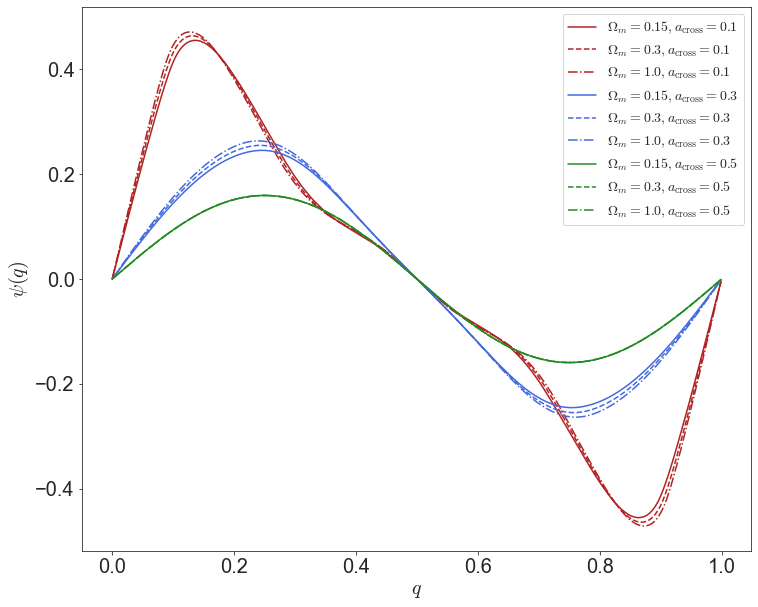

In [4]:
colors = ("firebrick", "royalblue", "forestgreen")
linestyles = ("-", "--", "-.")
plt.figure(figsize=(12, 10))
for iac, a_cross in enumerate([0.1, 0.3, 0.5]):
    for iOm, Om in enumerate([0.15, 0.3, 1.0]):
        q, psi = forward_model(Om, a_cross)
        plt.plot(q, psi, label=f"$\Omega_m = {Om}, a_{{\\mathrm{{cross}}}} = {a_cross}$",
                 color=colors[iac], ls=linestyles[iOm])
plt.legend(fontsize=14)
plt.xlabel(r"$q$")
plt.ylabel(r"$\psi(q)$")

### Derivatives

In [5]:
# Compute the derivatives of the forward-model using forward-mode AD with jax.jacfwd
q, psi = forward_model(0.3, 0.3, fwd_mode=True)
dpsi_dOm, dpsi_da_cross = jax.jacfwd(lambda Om, a_cross: forward_model(Om, a_cross, fwd_mode=True)[1], argnums=(0, 1))(0.3, 0.3)

eps = 1e-3
dpsi_dOm_fd = (forward_model(0.3 + eps, 0.3)[1] - forward_model(0.3 - eps, 0.3)[1]) / (2 * eps)
dpsi_da_cross_fd = (forward_model(0.3, 0.3 + eps)[1] - forward_model(0.3, 0.3 - eps)[1]) / (2 * eps)

In [6]:
# We can also compute the derivatives using reverse-mode automatic differentiation, implemented via the adjoint method
# (i.e. simulating the adjoint equations back in time).
# For mappings from a low-dimensional to a high-dimensional space, this is usually slower than forward-mode AD.
dpsi_dOm_rev, dpsi_da_cross_rev = jax.jacrev(lambda Om, a_cross: forward_model(Om, a_cross, fwd_mode=False)[1], argnums=(0, 1))(0.3, 0.3)

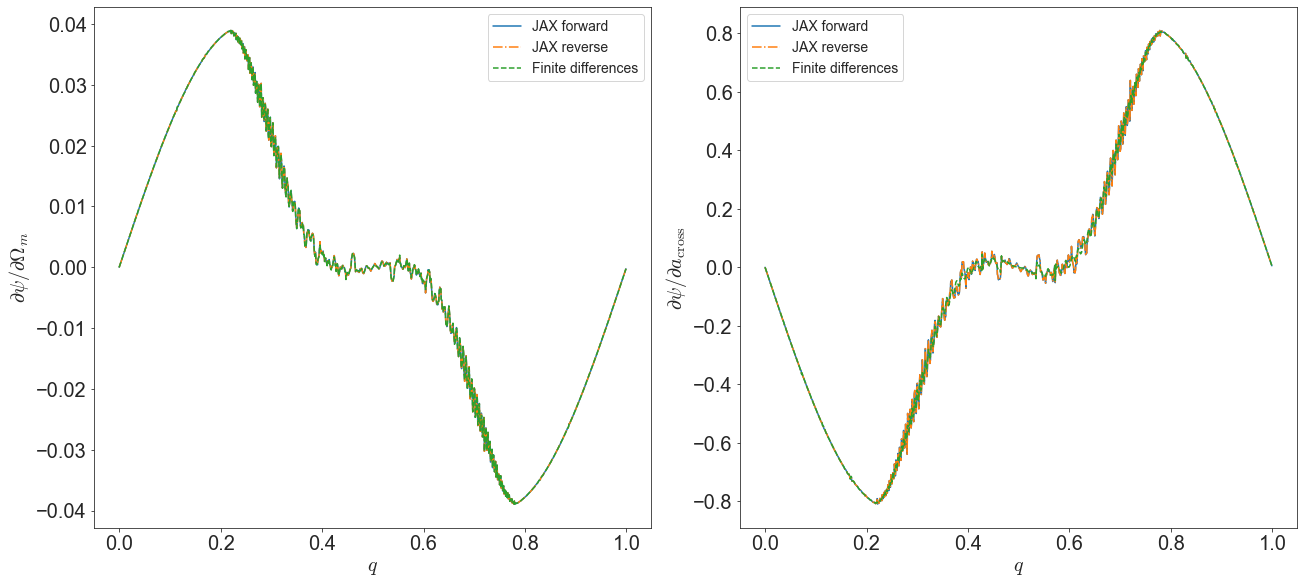

In [7]:
fig, axs = plt.subplots(1, 2, figsize=(18, 8), constrained_layout=True)
axs[0].plot(q, dpsi_dOm, label="JAX forward")
axs[0].plot(q, dpsi_dOm_rev, ls="-.", label="JAX reverse")
axs[0].plot(q, dpsi_dOm_fd, ls="--", label="Finite differences")
axs[0].set_xlabel(r"$q$")
axs[0].set_ylabel(r"$\partial \psi / \partial \Omega_m$")
axs[0].legend(fontsize=14)
axs[1].plot(q, dpsi_da_cross, label="JAX forward")
axs[1].plot(q, dpsi_da_cross_rev, ls="-.", label="JAX reverse")
axs[1].plot(q, dpsi_da_cross_fd, ls="--", label="Finite differences")
axs[1].set_xlabel(r"$q$")
axs[1].set_ylabel(r"$\partial \psi / \partial a_{\mathrm{cross}}$")
axs[1].legend(fontsize=14)

### Gradient descent
We can now write a simple gradient descent optimizer to find the best-fitting $a_{\mathrm{cross}}$ for some observed "noisy data".

In [8]:
np.random.seed(0)
Om = 0.3
a_cross_true = 0.3
observation = forward_model(Om, a_cross_true, fwd_mode=True)[1][:, 0] + 0.01 * np.random.randn(res)  # noisy "observation"
n_iter = 100
lr_a_cross = 3e-4

# Our loss function is the L2 error between the observation and the simulation
def l2_error(obs, data):
    return jnp.sqrt(jnp.sum((obs - data) ** 2))

# Single step of the gradient descent
def scan_body(carry, _):
    a_cross = carry
    sim = forward_model(Om, a_cross, fwd_mode=True)[1][:, 0]
    error = l2_error(observation, sim)
    error_grad = jax.jacfwd(lambda a: l2_error(observation, forward_model(Om, a, fwd_mode=True)[1][:, 0]), argnums=(0,))(a_cross)
    a_cross -= lr_a_cross * error_grad[0]
    return a_cross, (a_cross, error)

In [9]:
# Run the optimization
init = 0.1
_, (a_cross, errors) = jax.lax.scan(scan_body, init, jnp.arange(n_iter))

In [10]:
print("a_cross for each iteration:", a_cross)

a_cross for each iteration: [0.10853869 0.11714512 0.12553473 0.13388699 0.14202537 0.14999414
 0.15776215 0.16532428 0.17263055 0.17977109 0.18669266 0.1934444
 0.2000018  0.20637667 0.21259542 0.21864224 0.22452927 0.23025553
 0.23581909 0.241229   0.24647203 0.25155334 0.25646555 0.26119528
 0.2657268  0.27004699 0.27412272 0.27791591 0.28139829 0.28453088
 0.28728807 0.28966122 0.29163864 0.29328795 0.29461037 0.29568981
 0.29655379 0.29724034 0.29777338 0.2982005  0.29854882 0.29883507
 0.29905522 0.29923182 0.2993706  0.29947434 0.29955538 0.29961772
 0.29967028 0.29971404 0.29974966 0.29977674 0.2997993  0.29981862
 0.29983394 0.29984693 0.29985789 0.29986523 0.29987251 0.2998786
 0.29988276 0.29988576 0.29988781 0.29988972 0.29989136 0.29989309
 0.29989458 0.29989586 0.29989692 0.29989703 0.29989708 0.29989713
 0.29989716 0.2998972  0.29989726 0.29989735 0.29989743 0.29989748
 0.29989752 0.29989755 0.29989758 0.2998976  0.29989762 0.29989763
 0.29989765 0.29989767 0.29989769 0.

In [11]:
print("errors:", errors)

errors: [4.37395526 4.12750829 3.8817012  3.64605153 3.41630603 3.19765037
 2.98906964 2.79111392 2.60365992 2.42755276 2.26016575 2.10236479
 1.95268498 1.81126106 1.67750689 1.55052973 1.43039432 1.3165708
 1.20889845 1.10720273 1.01115408 0.92090482 0.83625042 0.75730192
 0.68424708 0.61736065 0.55692171 0.5034411  0.45738757 0.41896127
 0.3881979  0.36465375 0.34739964 0.33543842 0.32726409 0.32198958
 0.31847668 0.31624877 0.31484772 0.31399544 0.31344523 0.31307686
 0.31283516 0.31268996 0.31259745 0.31254036 0.31250818 0.31248915
 0.31247699 0.31246851 0.31246272 0.31245902 0.31245679 0.31245522
 0.31245411 0.31245339 0.31245287 0.31245254 0.31245237 0.3124522
 0.3124521  0.31245205 0.31245202 0.31245201 0.312452   0.31245199
 0.31245198 0.31245197 0.31245197 0.31245197 0.31245197 0.31245197
 0.31245197 0.31245197 0.31245197 0.31245197 0.31245197 0.31245197
 0.31245197 0.31245197 0.31245197 0.31245197 0.31245197 0.31245197
 0.31245197 0.31245197 0.31245197 0.31245197 0.31245197 